# String Simulation Analysis

This notebook will help you analyse the convergence of the string-method and if you are lucky extract a nice free energy surface. 

In [1]:
import numpy as np
import glob as glob
from math import ceil
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from MDAnalysis.analysis.align import AlignTraj
import MDAnalysis as mda
import nglview as nv
import pickle
import logging
import sys
import os

logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyemma").setLevel(logging.NOTSET)

In [2]:
def colorbar(mappable, cmap, norm, label0, size=10):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    cbar.set_label(label0, size=size)
    return cbar

In [3]:
plt.rcParams["axes.facecolor"] = "#f9f9fb"
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 2
plt.rcParams["axes.grid"] = True
plt.rcParams["lines.solid_capstyle"] = "round"

In [4]:
def natural_sort(l):
    """
    Takes as input a list l of strings and sorts it with natural order.
      Parameters
      ----------
      l: list of strings.
      Returns
      -------
      l sorted
    """
    from re import split

    assert isinstance(l, list), "l is not a list!"
    for i in l:
        assert isinstance(i, str), "List contains non-string elements."
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

# String Convergence Analysis

## Extract CVs

In the cell bellow you can select which will be the simulation directory (in case this notebook is elsewhere). If the notebook is in the simulation directory just leave it as ".".

In [5]:
simulation_directory = "../../string_sims/TMD_initial_path/influx_apo_gate_CV"
#simulation_directory = "../../string_sims/TMD_initial_path/efflux_BFRU_gate_CV"
os.chdir(simulation_directory)
os.getcwd()

'/data2/GLUT5_string/string/string_sims/TMD_initial_path/influx_apo_gate_CV'

Load the strings in the `strings` variable.

In [11]:
files = natural_sort(glob.glob("./strings/string*txt"))

In [12]:
strings = np.array([np.loadtxt(file).T for file in files])

In [13]:
with open("cv.pkl", "rb") as file:
    cvs, ndx_groups = pickle.load(file)

In [14]:
print("String details")
print("")
print(f"Number of string: {strings.shape[0]}")
print(f"Number of cvs: {strings.shape[1]}")
print(f"Number of beads per string: {strings.shape[2]}")

String details

Number of string: 354
Number of cvs: 2
Number of beads per string: 16


# Analyze string convergence
In these next plots you will be able to study the convergence of the string. At convergence the strings should be oscillating around an equilibrium position and not drift over the different iterations.

## Strings as a function of time
In this plot we can see the evolution of each string CV as function of the timeration number separatelly.

You can change two parameters in these plots the `start_iteration` before which all data is not plotted and the `n_average` which is the number of strings iterations to average in one block of strings. This is done in order to cancel some of the noisyness in the representation, to reduce the number of strings in the plot and to see more clearly if there is average drift.

+ borrar último string
+ probar con el GPCR

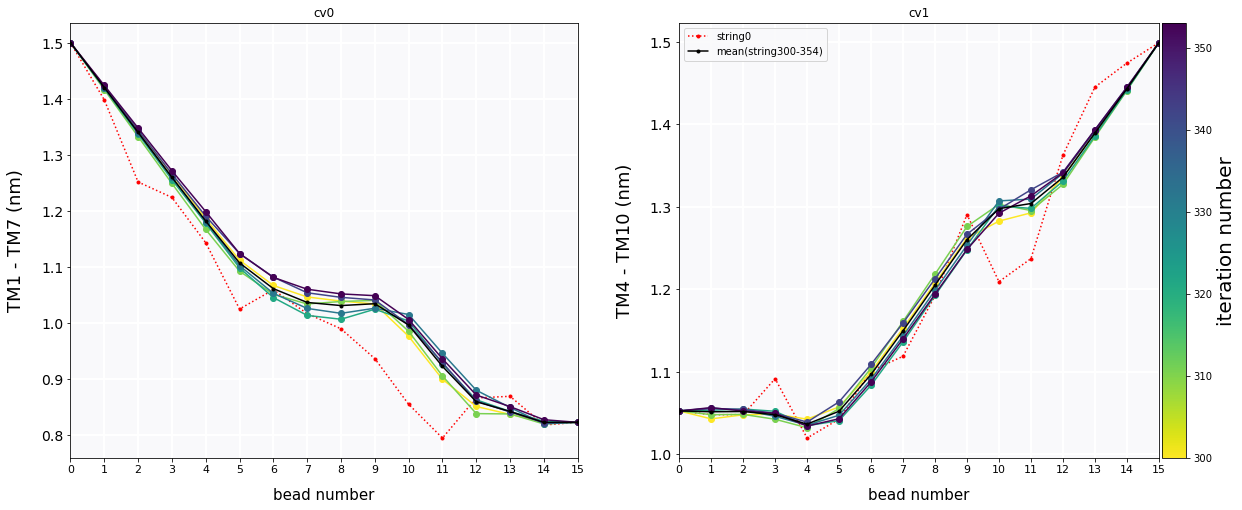

In [16]:
start_iteration = 300
n_average = 10
fill_std = False

n_plots = strings.shape[1]
n_strings = strings.shape[0]
fig, ax = plt.subplots(ceil(n_plots / 2), 2, figsize=(20, 8 * ceil(n_plots / 2)))
ax = ax.flatten()
cmap = plt.cm.viridis_r
n_colors = (n_strings - start_iteration) // n_average + 1
colors = cmap(np.linspace(0, 1, n_colors))  # yellow to blue
norm = mpl.colors.Normalize(vmin=start_iteration, vmax=n_strings - 1)

for i, a in enumerate(ax[:n_plots]):
    a.plot(strings[0, i, :], ls=":", marker=".", label="string0", color="r")
    for jj, j in enumerate(range(start_iteration, n_strings, n_average)):
        string = np.mean(strings[j : j + n_average, i, :], axis=0)
        a.plot(string, ls="-", marker="o", color=colors[jj])
    av = np.mean(strings[start_iteration:, i, :], axis=0)
    std = np.std(strings[start_iteration:, i, :], axis=0)
    if fill_std:
        a.fill_between(
            np.arange(len(av)),
            av + std,
            av - std,
            alpha=0.4,
            label=f"std(string{start_iteration}-{n_strings})",
        )
    a.plot(
        av,
        ls="-",
        marker=".",
        color="k",
        label=f"mean(string{start_iteration}-{n_strings})",
    )
    a.set_ylabel(
        f"{list(ndx_groups.keys())[2*i]} - {list(ndx_groups.keys())[2*i+1]} (nm)",
        size=18,
        labelpad=16,
    )
    a.set_xlabel("bead number", size=15, labelpad=13)
    a.set_xlim(left=0, right=strings.shape[2] - 1)
    a.xaxis.set_minor_locator(MultipleLocator(1))
    a.xaxis.set_major_locator(MultipleLocator(1))
    a.yaxis.set_minor_locator(MultipleLocator(0.1))
    a.yaxis.set_major_locator(MultipleLocator(0.1))
    a.grid(which="minor")
    a.tick_params(axis="y", labelsize=14)
    a.tick_params(axis="x", labelsize=11)
    a.set_title(f"cv{i}")
    if i % 2 != 0:
        a.legend()
        cbar = colorbar(a, cmap, norm, "iteration number", 20)
if n_plots % 2:
    fig.delaxes(ax[-1])

## Evolution of beads with iterations

In this plot the trajectory of beads cvs over iterations is presented. You can observe if the beads are stable or drifting in some direction. In this plot you can choose one parameter, `n_rolling_average`, which determines the size of the rolling average window applied to smooth-out the noisyness.

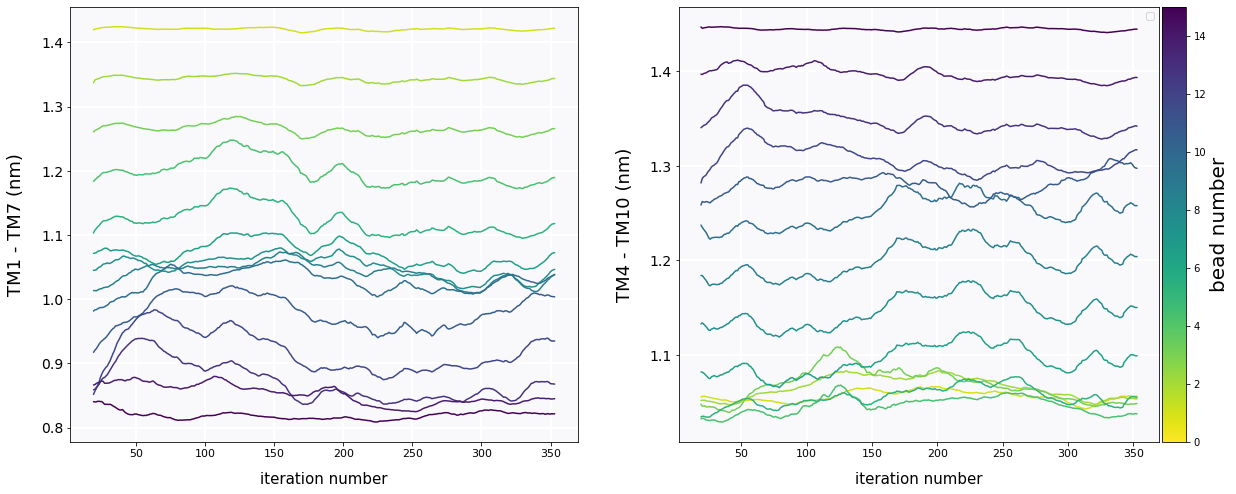

In [17]:
n_rolling_average = 20

n_strings = strings.shape[0]
n_cvs = strings.shape[1]
n_beads = strings.shape[2]
cmap = plt.cm.viridis_r
colors = cmap(np.linspace(0, 1, n_beads - 1))  # yellow to blue
norm = mpl.colors.Normalize(vmin=0, vmax=n_beads - 1)
fig, ax = plt.subplots(ceil(n_cvs / 2), 2, figsize=(20, 8 * ceil(n_cvs / 2)))
ax = ax.flatten()
for i in range(n_cvs):
    for j in range(1, n_beads - 1):
        y = np.convolve(
            strings[:, i, j],
            np.ones((n_rolling_average,)) / n_rolling_average,
            mode="valid",
        )
        x = np.arange(n_strings)[n_rolling_average - 1 :]
        ax[i].plot(x, y, color=colors[j])
        ax[i].set_ylabel(
            f"{list(ndx_groups.keys())[2*i]} - {list(ndx_groups.keys())[2*i+1]} (nm)",
            size=18,
            labelpad=16,
        )
        ax[i].set_xlabel("iteration number", size=15, labelpad=13)
        ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))
        ax[i].yaxis.set_major_locator(MultipleLocator(0.1))
        ax[i].grid(which="minor")
        ax[i].tick_params(axis="y", labelsize=14)
        ax[i].tick_params(axis="x", labelsize=11)
    if i % 2 != 0:
        ax[i].legend()
        cbar = colorbar(ax[i], cmap, norm, "bead number", 20)
if n_plots % 2:
    fig.delaxes(ax[-1])

## Evolution over iterations of pairs of cvs
In this plot you can see the evolution of the string with iterations projected onto two chosen cvs. The plots are just like in the previous section.

You can choose your pair of cvs with the variables `cv_0` and `cv_1`.

In [18]:
print("CV numbers")
ndx_groups_list = list(ndx_groups)
for i, cv in enumerate(cvs):
    print(f"CV {i} is {ndx_groups_list[cv[0]-1]} - {ndx_groups_list[cv[1]-1]}")

CV numbers
CV 0 is TM1 - TM7
CV 1 is TM4 - TM10


In [19]:
cv_0 = 1
cv_1 = 0

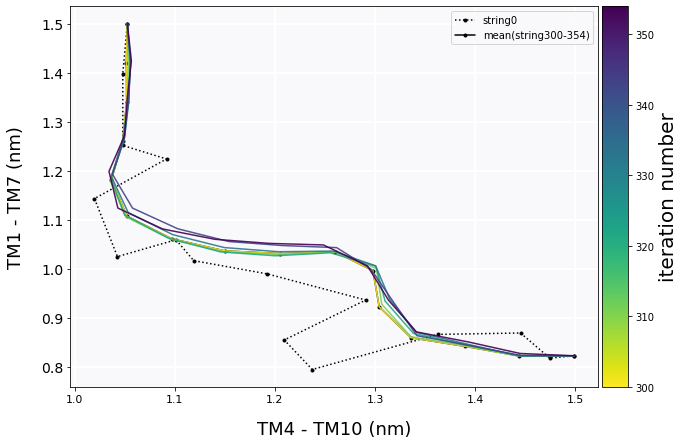

In [21]:
start_iteration = 300
n_average = 10

n_strings = strings.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
cmap = plt.cm.viridis_r
n_colors = (n_strings - start_iteration) // n_average + 1
colors = cmap(np.linspace(0, 1, n_colors))  # yellow to blue
norm = mpl.colors.Normalize(vmin=start_iteration, vmax=n_strings)
ax.plot(
    strings[0, cv_0, :],
    strings[0, cv_1, :],
    ls=":",
    marker=".",
    label="string0",
    color="k",
)
av_0 = np.mean(strings[start_iteration:, cv_0, :], axis=0)
std_0 = np.std(strings[start_iteration:, cv_0, :], axis=0)
av_1 = np.mean(strings[start_iteration:, cv_1, :], axis=0)
std_1 = np.std(strings[start_iteration:, cv_1, :], axis=0)
ax.plot(
    av_0,
    av_1,
    ls="-",
    marker=".",
    color="k",
    label=f"mean(string{start_iteration}-{n_strings})",
)

for jj, j in enumerate(range(start_iteration, n_strings, n_average)):
    av_0 = np.mean(strings[j:, cv_0, :], axis=0)
    std_0 = np.std(strings[j:, cv_0, :], axis=0)
    av_1 = np.mean(strings[j:, cv_1, :], axis=0)
    std_1 = np.std(strings[j:, cv_1, :], axis=0)
    ax.plot(
        av_0, av_1, color=colors[jj], alpha=0.9
    )   ## here I removed the errorbars, I don't like them. If you want them back, can see Sergio's string_analysis


ax.set_ylabel(
    f"{ndx_groups_list[cv_1*2]} - {ndx_groups_list[cv_1*2+1]} (nm)",
    size=18,
    labelpad=16,
)
ax.set_xlabel(
    f"{ndx_groups_list[cv_0*2]} - {ndx_groups_list[cv_0*2+1]} (nm)",
    size=18,
    labelpad=16,
)

ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(which="minor")
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=11)
ax.legend()
cbar = colorbar(ax, cmap, norm, "iteration number", 20)

## Evolution over CVs that are a function of the cvs

If you are interested in studying the convergence of cvs that are a function of CVs (for example averaging over symmetrical distances). You can construct a `reduced_string` array in which cvs are a function of the cvs used for the string method. In the example bellow, we produce two cvs which are the mean of cvs used in the string method simulation. Then, similar plotting as before can be done. 

In addition if you are interested in the convergence of some other cv which is not a function of the cvs used in the string method you can also study them! Just extract the average value of that particular CV in the `md/*/*/restrained/traj_comp.xtc` for all the restrained simulation and shape them into an `reduced_string` numpy array with shape (n_iterations, n_cvs, n_beads).

If this sort of analysis is meaningless in your system, for example because the chosen cvs are very diagnostic, please ignore this section.

In [15]:
reduced_string = np.hstack(
    [
        np.mean(strings[:, 0:2, :], axis=1, keepdims=True),
        np.mean(strings[:, 6:, :], axis=1, keepdims=True),
    ]
)
reduced_string_labels = ["X (nm)", "Y (nm)"]

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


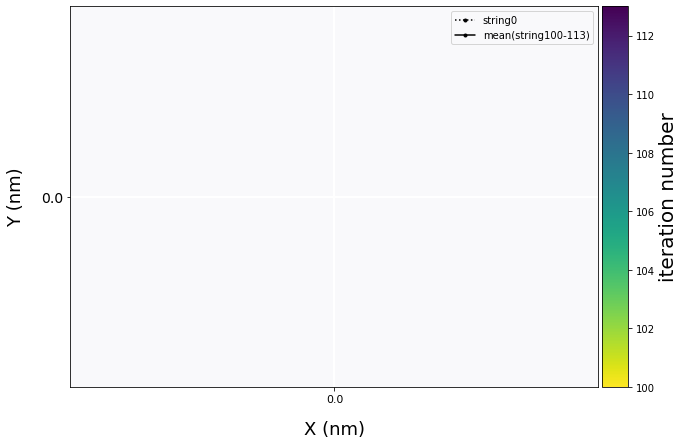

In [16]:
start_iteration = 100
n_average = 40

n_strings = strings.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
cmap = plt.cm.viridis_r
n_colors = (n_strings - start_iteration) // n_average + 1
colors = cmap(np.linspace(0, 1, n_colors))  # yellow to blue
norm = mpl.colors.Normalize(vmin=start_iteration, vmax=n_strings)
ax.plot(
    reduced_string[0, 0, :],
    reduced_string[0, 1, :],
    ls=":",
    marker=".",
    label="string0",
    color="k",
)
av_0 = np.mean(reduced_string[start_iteration:, 0, :], axis=0)
std_0 = np.std(reduced_string[start_iteration:, 0, :], axis=0)
av_1 = np.mean(reduced_string[start_iteration:, 1, :], axis=0)
std_1 = np.std(reduced_string[start_iteration:, 1, :], axis=0)
ax.plot(
    av_0,
    av_1,
    ls="-",
    marker=".",
    color="k",
    label=f"mean(string{start_iteration}-{n_strings})",
)

for jj, j in enumerate(range(start_iteration, n_strings, n_average)):
    av_0 = np.mean(reduced_string[j:, 0, :], axis=0)
    std_0 = np.std(reduced_string[j:, 0, :], axis=0)
    av_1 = np.mean(reduced_string[j:, 1, :], axis=0)
    std_1 = np.std(reduced_string[j:, 1, :], axis=0)
    ax.errorbar(
        av_0, av_1, fmt="--", xerr=std_0, yerr=std_1, color=colors[jj], alpha=0.9
    )


ax.set_ylabel(
    reduced_string_labels[1], size=18, labelpad=16,
)
ax.set_xlabel(
    reduced_string_labels[0], size=18, labelpad=16,
)

ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(which="minor")
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=11)
ax.legend()
cbar = colorbar(ax, cmap, norm, "iteration number", 20)

# Free Energy Surface

Once your strings are converged, the swarms are sampling over and over the same part of phase space and we can discretrize it and do statistics on the jumps. This will result in a free energy surface along some cv, which may not need to be the ones that parametrize the string. It is very important to keep in mind that a converged string does not imply a converged FES and it might be necessary to do one or two (or more) hundred additional iterations.


Now instead of using the data in `strings/string*.xtx` we will use the data in `md/*/*/s*/pullx.xvg` if we want to use the cvs of the string. Otherwise, you add here code that reads `md/*/*/s*/traj_comp.xtc`, calculates your desired cv and then shapes the data into the correct shape `(n_iterations*n_swarms_per_iter*n_beads, n_frames_per_iter, n_cvs)`. 

The path of `sys.path.append` should lead to the library `string-method-gmxapi`  

In [22]:
sys.path.append("../../../string-method-gmxapi/")

from stringmethod.config import *
from stringmethod.postprocessing import *

2021-08-03 10:07:47 root-INFO: Setting up logging for gmxapi package.
2021-08-03 10:07:47 gmxapi-INFO: Importing gmxapi.
2021-08-03 10:07:47 gmxapi.operation-INFO: Importing gmxapi.operation
2021-08-03 10:07:47 gmxapi.commandline-INFO: Importing gmxapi.commandline
2021-08-03 10:07:47 gmxapi.simulation.workflow-INFO: Importing gmx.workflow
2021-08-03 10:07:47 gmxapi.simulation.workflow-INFO: Using schema version gmxapi_workspec_0_1.
2021-08-03 10:07:47 gmxapi.mdrun-INFO: Importing gmxapi.simulation.mdrun
2021-08-03 10:07:47 gmxapi.read_tpr-INFO: Importing gmxapi.simulation.read_tpr
2021-08-03 10:07:47 gmxapi.modify_input-INFO: Importing gmxapi.simulation.modify_input
2021-08-03 10:07:47 stringmethod-0-INFO: Using 1 MPI ranks 


In [23]:
def load_swarm_data(extract, first_iteration=1, last_iteration=None):
    if last_iteration == None:
        last_iteration = sys.maxsize
    if extract:
        config = load_config("config_postprocessing.json")  #was a bug with the use_api command in the new config.json

        ce = CvValueExtractor.from_config(
            config=config,
            first_iteration=first_iteration,  # Exclude the first iterations to let the system equilibrate.
            last_iteration=last_iteration,  # Usefull to make blocks of the simulation
        )
        ce.run()
        ce.persist()
        
        os.rename("postprocessing/cv_coordinates.npy", "postprocessing/cv_coordinates.iterations.%i_%i.npy" \
                 %(first_iteration, last_iteration))
    
    
    return np.load("postprocessing/cv_coordinates.iterations.%i_%i.npy" \
                 %(first_iteration, last_iteration))


In [24]:
print('Iterations that have already been processed:')
print([x for x in os.listdir('./postprocessing') if x.startswith("cv_coordinates")])
#print([x for x in os.listdir('%s/postprocessing' %simulation_directory[:-1]) if x.startswith("cv_coordinates")])

Iterations that have already been processed:
['cv_coordinates.iterations.120_150.npy', 'cv_coordinates.iterations.90_190.npy', 'cv_coordinates.iterations.155_250.npy', 'cv_coordinates.iterations.35_135.npy', 'cv_coordinates.iterations.110_210.npy', 'cv_coordinates.iterations.200_255.npy', 'cv_coordinates.iterations.240_250.npy', 'cv_coordinates.iterations.30_110.npy', 'cv_coordinates.iterations.120_140.npy', 'cv_coordinates.iterations.10_40.npy', 'cv_coordinates.iterations.120_220.npy', 'cv_coordinates.iterations.20_100.npy', 'cv_coordinates.iterations.40_75.npy', 'cv_coordinates.iterations.30_54.npy', 'cv_coordinates.iterations.1_250.npy', 'cv_coordinates.iterations.55_255.npy', 'cv_coordinates.iterations.155_255.npy', 'cv_coordinates.iterations.160_240.npy', 'cv_coordinates.iterations.140_220.npy', 'cv_coordinates.iterations.100_140.npy', 'cv_coordinates.iterations.200_300.npy', 'cv_coordinates.iterations.100_120.npy', 'cv_coordinates.iterations.10_90.npy', 'cv_coordinates.iterations

The `load_swarm_data` function will load the swarm data in the `cv_coordinates`. If you set `extract=True` it will read the data from the swarm files. If you have done this previously you can set `extract=False` so the function just reads `postprocessing/cv_coordinates.npy`. `first_iteration` can be used to exclude initial swarms as equilibration and `last_iteration` can be done to exclude some iterations for example if you want to estimate the FES convergence by comparing blocks of data.

In [25]:
first_iteration=280
last_iteration=352
cv_coordinates = load_swarm_data(extract=True, first_iteration=first_iteration, last_iteration=last_iteration)
print(np.shape(cv_coordinates))

2021-08-03 10:08:02 stringmethod-0-INFO: Remember to remove unfinished strings
(32704, 2, 2)


Since the FES that is easy to visualize can only be 1D or 2D we need to reduce the dimensionality of the CVs. For this there are several options:
+ You can choose a couple of cvs or one

In [26]:
my_cvs = [1,0] #IC gate, EC gate
#my_cvs = [1]
cv_coordinates_clean = cv_coordinates[:, :, my_cvs]

+ You can do some function of the cvs, like the mean of several:

In [ ]:
cv_coordinates_clean = np.concatenate(
    [
        np.concatenate([cv_coordinates[:, :, 0:1], cv_coordinates[:, :, 1:2]], axis=0),
        np.concatenate([cv_coordinates[:, :, 6:7], cv_coordinates[:, :, 7:8]], axis=0),
    ],
    axis=2,
)

+ You can of course make your own function that extracts cvs from the trajectory and makes a cv_coordinates_clean with the correct shape.

Of the above cells only run the one you are more interested in.

In [27]:
def calculate_transition_matrix(
    cv_coordinates, n_grid_points=15, T=300, kB=0.0019872041
):
    config = load_config("config_postprocessing.json")
    tc = TransitionCountCalculator.from_config(
        config=config,
        # You probably want to play around with n_grid_points.
        # It sets the resolution. Its optimal value depends on your swarm trajectory length and sample size
        n_grid_points=n_grid_points,
        cv_coordinates=cv_coordinates,
    )
    tc.run()
    tc.persist()
    fc = FreeEnergyCalculator.from_config(
        config=config, grid=tc.grid, transition_count=tc.transition_count, T=T, kB=kB
    )
    fc.run()
    fc.persist()
    return tc.grid, fc.free_energy

This functions takes the `cv_coordinates_clean` numpy array and calculates a transition matrix by doing a simple grid on the cv space. It also calculates the probability of transition using the master equation and this results in the calculation of a FES. `n_grid_points` choose the number of grid points of the grid, the coarse the grid the more detailed (and noisy) the FES. This parameter should be varied to obtain an acceptable signal-to-noise ration. The temperature `T` and the value of `kB` can be set too. `kB` is used to give units to the FES. In this example we will use "kBT" units since kBT=1.

In [28]:
grid, free_energy = calculate_transition_matrix(
    cv_coordinates_clean, n_grid_points=20, T=303.15, kB=0.0019872041
)

2021-08-03 10:08:19 stringmethod-0-WARNING: Found 81 accessible states, 319 inaccessible states and 0 states with no starting points.
2021-08-03 10:08:24 stringmethod-0-DEBUG: Converged with master equation after 7198 iterations


../../../string-method-gmxapi/stringmethod/postprocessing/free_energy_calculation.py:71: RuntimeWarning: divide by zero encountered in log
  fe[row_idx, col_idx] = -self.kB * self.T * np.log(p)


In [29]:
def show_fes(grid, free_energy, fe_cut_off=None, cv_labels=["cv0 (nm)", "cv1 (nm)"], f_min=None, f_max=None):
    if fe_cut_off == None:
        fe_cut_off = sys.maxsize
    free_energy[free_energy > fe_cut_off] = np.nan
    cv_0 = grid[:, 0]
    fig, ax = plt.subplots(1, 1)
    if free_energy.shape[1] == 1:
        ax.plot(cv_0, free_energy, "--o")
        ax.set_ylabel("Free Energy (kT)")
    else:
        cv_1 = grid[:, 1]
        im = plt.contourf(
            cv_0,
            cv_1,
            free_energy.T,
            levels=20,
        #    norm=mpl.colors.PowerNorm(gamma=1 / 3),
            # Used to be rainbow cmap=plt.cm.rainbow
            cmap=plt.cm.viridis,
            vmin=f_min,
            vmax=f_max,
        )
        cbar = plt.colorbar(im)
        cbar.set_label("Free Energy (kT)")
        ax.set_ylabel(cv_labels[1])
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.set_xlabel(cv_labels[0])
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    fig.tight_layout()
    return fig, ax

The function bellow takes the `grid` and `free_energy` arrays from the previous step and plots the free energy surface. The function returns the matplotlib `fig` and `ax` for you to format further if you want. `fe_cut_off` is a maximum value of free energy overwhich nothing is plotted and `cv_labels` are the labels of the cvs.

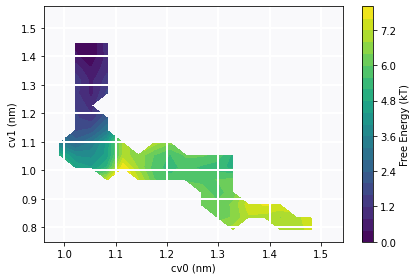

In [30]:
fig, ax = show_fes(
    grid, free_energy, fe_cut_off=None, cv_labels=["cv0 (nm)", "cv1 (nm)"]
)

To save the plot.

In [120]:
#grid_90, free_energy_90 = grid, free_energy
#grid_70, free_energy_70 = grid, free_energy
#grid100, free_energy100 = grid, free_energy
#grid110, free_energy110 = grid, free_energy
#grid120, free_energy120 = grid, free_energy
fes_inf.append(free_energy)

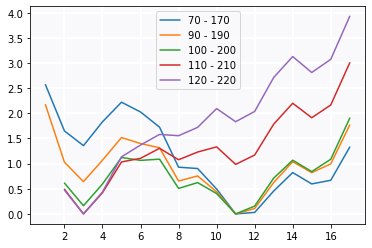

In [102]:
plt.plot(free_energy_70, label = '70 - 170')
plt.plot(free_energy_90, label = '90 - 190')
plt.plot(free_energy100, label = '100 - 200')
plt.plot(free_energy110, label = '110 - 210')

plt.plot(free_energy120, label = '120 - 220')

plt.legend()

In [103]:
#fig.savefig(f"{simulation_directory}/free_energy.svg", transparent=True)

# Sarah section - troubleshooting influx apo problems:


Don't change these

In [31]:
n_grid_points = 40    #20 is default, 40 for higher resolution
max_iterations = 350   # max strings run by influx apo
skip_interval = 10   #step to choose between intervals (eg. if 10 - do 100-180, 110-190, 120-200. etc)

Use the functions above to paste in many iterations of FES and grid data

In [32]:
def get_iterative_FES(n_grid_points, max_iterations, skip_interval, cv_choice):
    if cv_choice == "IC_gate":
        my_cv = [1]
    elif cv_choice == "EC_gate":
        my_cv = [0]
    
    max_start_iterations = max_iterations - 80   #interval we are choosing for start-stop for transition matrix
    
    
    ## init arrays to store info
    free_energy_by_iterations = np.zeros((int(max_start_iterations/10),n_grid_points,1))
    grid_by_iterations = np.zeros((int(max_start_iterations/10),n_grid_points,1))  #right now this is really custom to our problem, so be careful 

    
    ## loop through each chunk
    for iteration_group, n in enumerate(np.arange(0, max_start_iterations, skip_interval)):  ## of max iteration - 80
        if n == 0:
            first_iteration = 1
            last_iteration = first_iteration + 79
        else:
            first_iteration = n
            last_iteration = first_iteration + 80
        
        ## the extract = True will only have to be run once
        cv_coordinates = load_swarm_data(extract=True, first_iteration=first_iteration, last_iteration=last_iteration)
        cv_coordinates_clean = cv_coordinates_clean = cv_coordinates[:, :, my_cv]  #IC gate only right now

        grid, free_energy = calculate_transition_matrix(
        cv_coordinates_clean, n_grid_points=n_grid_points, T=303.15, kB=0.0019872041)

        free_energy_by_iterations[iteration_group] = free_energy
        grid_by_iterations[iteration_group] = grid
    
    return free_energy_by_iterations, grid_by_iterations

In [33]:
free_energy_by_iterations_IC, grid_by_iterations_IC = get_iterative_FES(n_grid_points=n_grid_points,\
                                                                       max_iterations=max_iterations, \
                                                                       skip_interval=skip_interval, \
                                                                       cv_choice="IC_gate")

2021-08-03 10:10:20 stringmethod-0-INFO: Remember to remove unfinished strings
2021-08-03 10:10:53 stringmethod-0-WARNING: Found 32 accessible states, 8 inaccessible states and 0 states with no starting points.
2021-08-03 10:10:53 stringmethod-0-DEBUG: Converged with master equation after 1849 iterations
2021-08-03 10:10:53 stringmethod-0-INFO: Remember to remove unfinished strings
2021-08-03 10:11:09 stringmethod-0-WARNING: Found 32 accessible states, 8 inaccessible states and 0 states with no starting points.
2021-08-03 10:11:09 stringmethod-0-DEBUG: Converged with master equation after 1599 iterations
2021-08-03 10:11:09 stringmethod-0-INFO: Remember to remove unfinished strings
2021-08-03 10:11:23 stringmethod-0-WARNING: Found 32 accessible states, 8 inaccessible states and 0 states with no starting points.
2021-08-03 10:11:23 stringmethod-0-DEBUG: Converged with master equation after 961 iterations
2021-08-03 10:11:23 stringmethod-0-INFO: Remember to remove unfinished strings
2021

In [34]:
free_energy_by_iterations_EC, grid_by_iterations_EC = get_iterative_FES(n_grid_points=n_grid_points,\
                                                                       max_iterations=max_iterations, \
                                                                       skip_interval=skip_interval, \
                                                                       cv_choice="EC_gate")

2021-08-03 10:17:02 stringmethod-0-INFO: Remember to remove unfinished strings
2021-08-03 10:17:11 stringmethod-0-WARNING: Found 32 accessible states, 8 inaccessible states and 0 states with no starting points.
2021-08-03 10:17:12 stringmethod-0-DEBUG: Converged with master equation after 1313 iterations
2021-08-03 10:17:12 stringmethod-0-INFO: Remember to remove unfinished strings
2021-08-03 10:17:21 stringmethod-0-WARNING: Found 32 accessible states, 8 inaccessible states and 0 states with no starting points.
2021-08-03 10:17:21 stringmethod-0-DEBUG: Converged with master equation after 1447 iterations
2021-08-03 10:17:21 stringmethod-0-INFO: Remember to remove unfinished strings
2021-08-03 10:17:31 stringmethod-0-WARNING: Found 32 accessible states, 8 inaccessible states and 0 states with no starting points.
2021-08-03 10:17:31 stringmethod-0-DEBUG: Converged with master equation after 1228 iterations
2021-08-03 10:17:31 stringmethod-0-INFO: Remember to remove unfinished strings
202

In [207]:
free_energy_by_iterations = free_energy_by_iterations_IC
grid_by_iterations = grid_by_iterations_IC

Shape of these is :
`# iterations groups`, `# grid points`, `# cvs`


Everything for EC is in reverse since for influx we start with out open and move in, so I thought it would be easier to compare IC & EC changes this way since now if you read left --> right this is how the protein should move too. 

Obviously, this is now spaghetti code

Text(0.5, 0, 'gate distance')

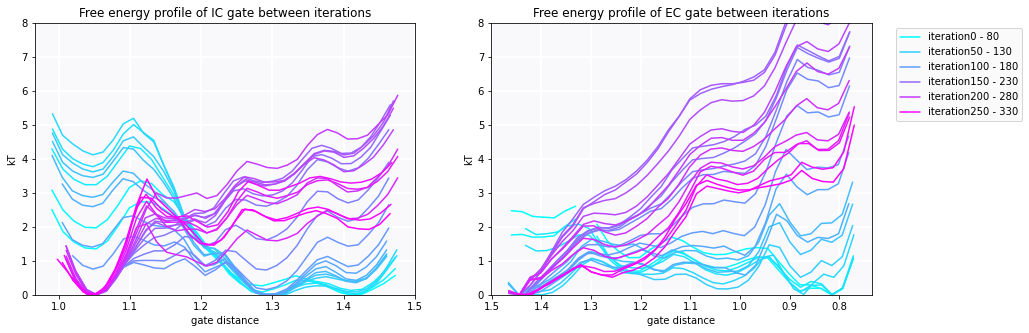

In [35]:
f, (ax_IC, ax_EC) = plt.subplots(ncols=2, figsize = (15,5))


## color determination
cmap_vals = plt.cm.get_cmap('cool')
color_vals = cmap_vals(np.linspace(0,1,np.shape(free_energy_by_iterations_IC)[0]))





for row in range(np.shape(free_energy_by_iterations_IC)[0]):
    if row % 5 == 0:
        ## just plot a few labels
        ax_IC.plot(grid_by_iterations_IC[row], free_energy_by_iterations_IC[row], c = color_vals[row], \
                 label = f"iteration{row * skip_interval} - {row * skip_interval + 80}")

         
        ax_EC.plot(grid_by_iterations_EC[row], free_energy_by_iterations_EC[row], c = color_vals[row], \
                 label = f"iteration{row * skip_interval} - {row * skip_interval + 80}")        
        
    else:
        ax_IC.plot(grid_by_iterations_IC[row], free_energy_by_iterations_IC[row], c = color_vals[row])
        ax_EC.plot(grid_by_iterations_EC[row], free_energy_by_iterations_EC[row], c = color_vals[row])

        
        
        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
ax_IC.set_title("Free energy profile of IC gate between iterations")
ax_EC.set_title("Free energy profile of EC gate between iterations")
ax_IC.set_ylabel("kT")
ax_EC.set_ylabel("kT")

ax_IC.set_ylim(0,8)
ax_EC.set_ylim(0,8)

## show in REVERSE
ax_EC.set_xlim(ax_EC.get_xlim()[::-1])

ax_IC.set_xlabel("gate distance")
ax_EC.set_xlabel("gate distance")


Now plotting per bead area

The plotting here is not perfect, as we transform the beads into their distances for these CVs and this is what the value `grid` will correspond to. But we do know that approximately certain distances should correspond to some bead

As the grid values corresponding to CV distances change slightly for iterations, this is **highly approximate** but can hopefully help diagnose which beads are completely screwy


EX: If we have 40 points on a grid, and 14 beads, 40/14 = 2.8 grid points represent 1 bead, so this is why we split it up into 3. 

I know we technically have 16 beads but these don't count in the FES calculation since they don't move

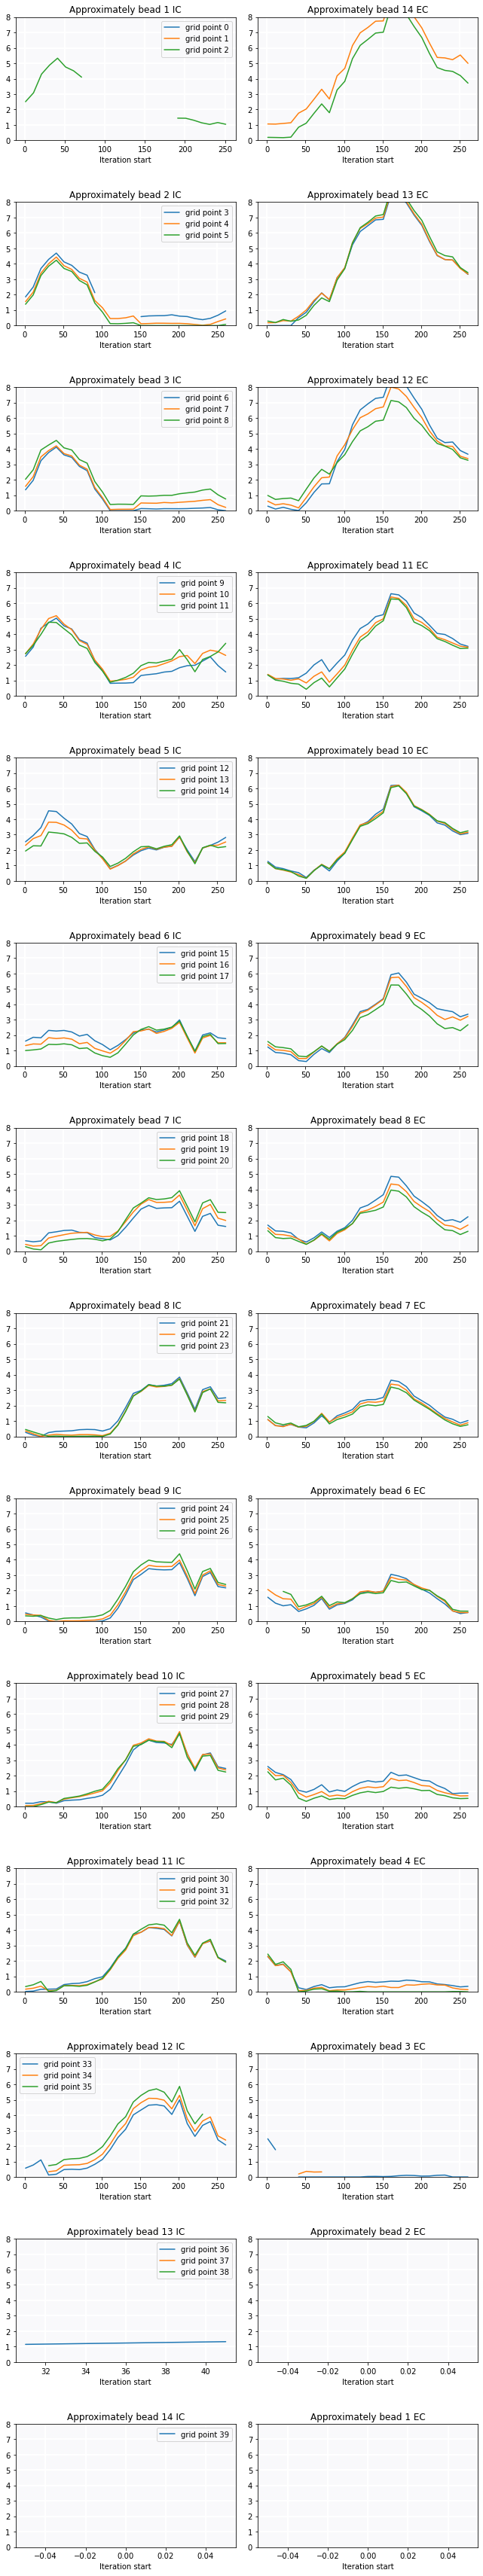

In [37]:
f, ax = plt.subplots(nrows=14, ncols=2, figsize = (11,13))
#ax = axs.ravel()
max_start_iterations = max_iterations - 80
ax_loc = 0
for grid_point in range(0, n_grid_points):
    if grid_point % 3 == 0 and grid_point != 0:   
        ### split up the grid points into bead-ish sized groups
        ax_loc = ax_loc + 1 
        
    ## plot IC gate on left side:
    ax[ax_loc,0].plot(np.arange(1, max_start_iterations, skip_interval), \
                        free_energy_by_iterations_IC[:,grid_point], label = f"grid point {grid_point}")
    ax[ax_loc,0].set_title(f'Approximately bead {ax_loc + 1} IC')   # bead 0 is fixed, so don't confuse ourselves

    
    
    
    # plot EC on right side
    ax[ax_loc,1].plot(np.arange(1, max_start_iterations, skip_interval), \
                        free_energy_by_iterations_EC[:,grid_point], label = f"grid point {grid_point}")
    ax[ax_loc,1].set_title(f'Approximately bead {14 - ax_loc} EC')   # bead 0 is fixed, so don't confuse ourselves

    
    
    
    
    ax[ax_loc,0].set_ylim(0,8)
    ax[ax_loc,1].set_ylim(0,8)

    ax[ax_loc,0].set_xlabel("Iteration start") 
    ax[ax_loc,1].set_xlabel("Iteration start") 

    ax[ax_loc,0].legend()
plt.subplots_adjust(top = 3.6, bottom=0.01, hspace=0.5, wspace=0.1)


In [234]:
np.shape(axs)

(14, 2)